# Reading TREx Spectrograph raw image data

Below we'll retrieve TREx Spectrograph data, read it, and do a bit of processing. An internet connection is required since we'll need to download data.

## Retrieve a minute of data

In [1]:
import requests

In [2]:
# 2020-03-21 06:30 UTC in Rabbit Lake, Manitoba, was a particularly good night
url = "https://data.phys.ucalgary.ca/sort_by_project/TREx/spectrograph/stream0/2020/03/03/rabb_spect-01/ut06/20200303_0630_rabb_spect-01_spectra.pgm.gz"
r = requests.get(url)

In [4]:
# save data to a local file
filename = "20200303_0630_rabb_spect-01_spectra.pgm.gz"
with open(filename, 'wb') as f:
    f.write(r.content)

## Read the data file

In [5]:
import trex_imager_readfile

In [6]:
img, meta, problematic_files = trex_imager_readfile.read_spectrograph(filename)

In [10]:
# the imager takes a picture every 15 seconds, so a 1-minute file usually contains 4 images
print("Image dimensions: %d x %d" % (img.shape[0], img.shape[1]))
print("Number of images: %d" % (img.shape[2]))

Image dimensions: 1024 x 256
Number of images: 4


In [11]:
# data for the first image
img[:,:,0]

array([[301, 303, 302, ..., 297, 303, 301],
       [302, 295, 302, ..., 302, 298, 299],
       [297, 303, 306, ..., 298, 303, 303],
       ...,
       [300, 297, 302, ..., 299, 303, 303],
       [300, 306, 299, ..., 300, 305, 300],
       [300, 302, 301, ..., 302, 297, 303]], dtype=uint16)

In [12]:
# metadata for first image
meta[0]

{'Project unique ID': 'trex',
 'Site unique ID': 'rabb',
 'Imager unique ID': 'spect-01',
 'Mode unique ID': 'spectra',
 'Geographic latitude': '58.227808',
 'Geographic longitude': '-103.680631',
 'Optical Configuration': 'Fisheye_Canon15mm_f2.8_SN34883,SLB-60-80-PM,Slit 250um,SLB-100B-200PM,Nikon_50mm_f1.2_SN277915',
 'Grating Model': 'Richardson/Newport 53015BK01-260R (600G 500nm 8.6d)',
 'Grating Serial Number': '1670-3-4-1',
 'Camera Model': 'Andor DU934P-BV',
 'Camera Serial Number': '21446',
 'CCD type': 'E2V CCD47-10',
 'CCD xsize': '1024 pixels',
 'CCD ysize': '1024 pixels',
 'Pixel depth': '16 bits',
 'CCD xbinned': '4',
 'CCD ybinned': '1',
 'VSSpeed index': '1',
 'VS Amplitude index': '0',
 'VS Amplitude': '0',
 'High Capacity Toggle': '0',
 'Requested Pre Amp gain': '1.0',
 'Current HS Speed': '1.0 MHz',
 'Requested Exposure': '13.0',
 'Conf file set CCD temperature': '-65C (+- 5C)',
 'Calibration reference': '20191006_spect-01_Rabbit_Lake_Field_Cal',
 'Calibration resolut

## Visualize the image

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

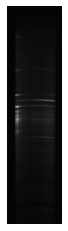

In [14]:
plt.imshow(img[:,:,0], cmap="gray")
plt.axis("off")
plt.show() 

# Let's scale the image so it's a bit brighter

In [15]:
# Pulled from SciPy. This function was depreated in 
# scipy v1.2.0, but it's quite useful for us.
import numpy as np
def bytescale(data, cmin=None, cmax=None, high=65535, low=0):
    if high > 65535:
        raise ValueError("`high` should be less than or equal to 65535.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint16)

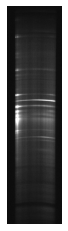

In [21]:
# scale the image with 200 as the floor and 2000 as the ceiling, then display
im_scaled = bytescale(img[:,:,0], cmin=100, cmax=500)
plt.imshow(im_scaled, cmap="gray")
plt.axis("off")
plt.show() 

The x-axis is the meridional axis of the image we collect (which really is a magnetic North/South slice of the sky), and the y-axis is the wavelength. Each visible horizontal line you see in the image is a different wavelength. From top to bottom in the above image, the wavelength is ordered with red (630.0nm) towards the top and blue near the bottom (427.8nm)

## Cleanup downloaded file

In [22]:
# remove the downloaded files
import os
os.remove(filename)